<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [1]:
# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# ## install finrl library
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [2]:
# import shutil
# import finrl
# import os

# # 1. Get the installed path of FinRL
# finrl_base = os.path.dirname(finrl.__file__)
# custom_model_path = "/content/models.py"  # Change if different

# # 2. Path to target file inside site-packages
# target_model_path = os.path.join(finrl_base, "agents", "stablebaselines3", "models.py")

# # 3. Replace the installed models.py with your uploaded one
# shutil.copy(custom_model_path, target_model_path)

# print(f"✅ Replaced: {target_model_path}")



<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline
import sys
sys.path.append(r"D:\FinRL-master\FinRL-master")

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint


import itertools

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [5]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class MetaGradientTuner(BaseCallback):
    def __init__(self, check_freq=10000, lr_bounds=(1e-5, 1e-3), sigma_bounds=(0.01, 0.5), verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.lr_min, self.lr_max = lr_bounds
        self.sigma_min, self.sigma_max = sigma_bounds
        self.best_mean_reward = -np.inf

    def _on_step(self) -> bool:
        if self.num_timesteps % self.check_freq == 0:
            if len(self.model.ep_info_buffer) > 0:
                mean_reward = np.mean([ep["r"] for ep in self.model.ep_info_buffer])

                # --- Adaptive Learning Rate ---
                if hasattr(self.model.policy, "optimizer"):
                    lr = self.model.policy.optimizer.param_groups[0]["lr"]
                    if mean_reward > self.best_mean_reward + 1e-6:
                        new_lr = max(lr * 0.9, self.lr_min)
                    else:
                        new_lr = min(lr * 1.1, self.lr_max)
                    self.model.policy.optimizer.param_groups[0]["lr"] = new_lr
                    if self.verbose:
                        print(f"[{self.num_timesteps}] Adjusted LR to {new_lr:.6f}")

                # --- Adaptive Action Noise (only for SAC/TD3) ---
                if hasattr(self.model, "action_noise") and self.model.action_noise is not None:
                    sigma = self.model.action_noise.sigma
                    if mean_reward > self.best_mean_reward + 1e-6:
                        new_sigma = np.clip(sigma * 0.9, self.sigma_min, self.sigma_max)
                    else:
                        new_sigma = np.clip(sigma * 1.1, self.sigma_min, self.sigma_max)
                    self.model.action_noise.sigma = new_sigma
                    if self.verbose:
                        print(f"[{self.num_timesteps}] Adjusted noise sigma to {new_sigma}")

                self.best_mean_reward = max(self.best_mean_reward, mean_reward)
        return True


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [6]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [7]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-10-01'
TRADE_START_DATE = '2023-10-01'
TRADE_END_DATE = '2025-06-01'

In [8]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                    end_date = TRADE_END_DATE,
                    ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
# yfp = YahooFinanceProcessor()
# df = yfp.download_data(['AXP', 'AMGN', 'AAPL'], '2010-01-01', '2010-02-01', '1m')
print(df)

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (113963, 8)
Price         date       close        high         low        open     volume  \
0       2010-01-04    6.424605    6.439315    6.375673    6.407194  493729600   
1       2010-01-04   39.913239   40.016962   39.111101   39.159506    5277400   
2       2010-01-04   32.637966   32.781535   32.215237   32.550232    6894300   
3       2010-01-04   43.777546   43.941185   42.702198   43.419098    6186700   
4       2010-01-04   39.403477   39.834189   38.703568   38.797789    7325600   
...            ...         ...         ...         ...         ...        ...   
113958  2025-05-30  299.781891  303.485610  293.754670  295.869661   16309300   
113959  2025-05-30  364.548553  366.395310  360.715302  360.715302    8726900   
113960  2025-05-30   43.260517   43.358928   42.601180   42.679905   26569500   
113961  2025-05-30   11.250000   11.330000   11.180000   11.190000   69213700   
113962  2025-05-30   98.489967   98.699477   96.374905   96.734066   2998010

In [9]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [10]:
df.shape

(113963, 8)

In [11]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.424605,6.439315,6.375673,6.407194,493729600,AAPL,0
1,2010-01-04,39.913239,40.016962,39.111101,39.159506,5277400,AMGN,0
2,2010-01-04,32.637966,32.781535,32.215237,32.550232,6894300,AXP,0
3,2010-01-04,43.777546,43.941185,42.702198,43.419098,6186700,BA,0
4,2010-01-04,39.403477,39.834189,38.703568,38.797789,7325600,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3875, 8)
Successfully added vix
Successfully added turbulence index


In [13]:
print(processed)

              date       close        high         low        open     volume  \
0       2010-01-04    6.424605    6.439315    6.375673    6.407194  493729600   
1       2010-01-04   39.913239   40.016962   39.111101   39.159506    5277400   
2       2010-01-04   32.637966   32.781535   32.215237   32.550232    6894300   
3       2010-01-04   43.777546   43.941185   42.702198   43.419098    6186700   
4       2010-01-04   39.403477   39.834189   38.703568   38.797789    7325600   
...            ...         ...         ...         ...         ...        ...   
112370  2025-05-29  296.068268  301.241535  292.920599  294.707899   16221100   
112371  2025-05-29  361.763428  362.402318  358.089899  359.717041    4590400   
112372  2025-05-29   42.640545   42.699588   42.296112   42.463409    9960400   
112373  2025-05-29   11.240000   11.240000   11.160000   11.210000    8877200   
112374  2025-05-29   96.873741   97.542178   96.624324   97.402505   14338000   

         tic  day       mac

In [14]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [15]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,6.424605,6.439315,6.375673,6.407194,493729600.0,0.0,0.0,6.445868,6.41445,100.0,66.666667,100.0,6.424605,6.424605,20.040001,0.0
1,2010-01-04,AMGN,39.913239,40.016962,39.111101,39.159506,5277400.0,0.0,0.0,6.445868,6.41445,100.0,66.666667,100.0,39.913239,39.913239,20.040001,0.0
2,2010-01-04,AXP,32.637966,32.781535,32.215237,32.550232,6894300.0,0.0,0.0,6.445868,6.41445,100.0,66.666667,100.0,32.637966,32.637966,20.040001,0.0
3,2010-01-04,BA,43.777546,43.941185,42.702198,43.419098,6186700.0,0.0,0.0,6.445868,6.41445,100.0,66.666667,100.0,43.777546,43.777546,20.040001,0.0
4,2010-01-04,CAT,39.403477,39.834189,38.703568,38.797789,7325600.0,0.0,0.0,6.445868,6.41445,100.0,66.666667,100.0,39.403477,39.403477,20.040001,0.0
5,2010-01-04,CRM,18.542521,18.718478,18.386389,18.490477,7906000.0,0.0,0.0,6.445868,6.41445,100.0,66.666667,100.0,18.542521,18.542521,20.040001,0.0
6,2010-01-04,CSCO,16.158171,16.256337,15.713150,15.778594,59853700.0,0.0,0.0,6.445868,6.41445,100.0,66.666667,100.0,16.158171,16.158171,20.040001,0.0
7,2010-01-04,CVX,42.603550,42.678992,42.118565,42.140116,10173800.0,0.0,0.0,6.445868,6.41445,100.0,66.666667,100.0,42.603550,42.603550,20.040001,0.0
8,2010-01-04,DIS,27.475876,28.058464,27.304527,27.844277,13700400.0,0.0,0.0,6.445868,6.41445,100.0,66.666667,100.0,27.475876,27.475876,20.040001,0.0
9,2010-01-04,GS,131.992035,132.884284,129.269522,129.681336,9135000.0,0.0,0.0,6.445868,6.41445,100.0,66.666667,100.0,131.992035,131.992035,20.040001,0.0


In [16]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [17]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)

100311
12064


In [18]:
train.tail()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3458,2023-09-29,UNH,489.152222,494.672516,488.773839,494.643412,3006200.0,4.0,4.758835,499.945960,450.959716,55.148633,128.373414,19.202196,475.052333,477.039836,17.52,57.508156
3458,2023-09-29,V,226.621841,229.597360,226.267144,229.410156,6045200.0,4.0,-3.060780,250.759362,223.639084,41.887479,-154.263252,36.909132,237.730120,236.732693,17.52,57.508156
3458,2023-09-29,VZ,28.312363,28.609376,28.277419,28.495811,19787600.0,4.0,-0.276669,30.421855,28.184127,41.243790,-137.570789,33.867241,29.353076,29.363413,17.52,57.508156
3458,2023-09-29,WBA,20.083014,20.254587,18.854915,18.963277,25663400.0,4.0,-1.050146,20.962601,18.592988,36.119167,-53.011609,26.754754,20.958936,23.656806,17.52,57.508156
3458,2023-09-29,WMT,52.092018,53.134313,51.850984,53.101742,18842400.0,4.0,0.139502,54.027439,52.110902,50.578505,-24.940985,17.468335,52.619028,51.954637,17.52,57.508156


In [19]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.064651,172.609320,169.271998,169.559193,52164500.0,0.0,-2.558756,183.367364,165.648051,45.243174,-87.976979,26.128841,176.366170,180.804583,17.610001,34.480626
0,2023-10-02,AMGN,252.198318,254.262794,250.370595,253.524127,1912300.0,0.0,3.867167,261.151695,237.536314,59.425477,72.229217,31.542890,247.539636,237.412812,17.610001,34.480626
0,2023-10-02,AXP,145.907852,146.317814,144.531558,144.873186,2657600.0,0.0,-3.052556,160.817401,143.761831,37.445506,-174.733061,36.526802,153.348366,158.819424,17.610001,34.480626
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480626
0,2023-10-02,CAT,262.851074,267.774933,261.419371,263.741058,1778200.0,0.0,-0.878851,277.101088,259.928755,51.346827,-69.196330,1.038631,268.083483,264.021850,17.610001,34.480626


In [20]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [21]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [22]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [24]:
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np
import copy

class DDPGTrainerWithNoise:
    def __init__(self, base_env, sigma=0.1, learning_rate=1e-4, gamma=0.99, tau=0.005, buffer_size=50000, batch_size=64, train_freq=(1, "step")):
        self.env = self._clone_env(base_env)
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.train_freq = train_freq

    def _clone_env(self, env):
        try:
            return copy.deepcopy(env)
        except Exception as e:
            print("[Warning] deepcopy failed. Using original env (unsafe). Error:", e)
            return env

    def build_model(self):
        n_actions = self.env.action_space.shape[-1]
        action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=self.sigma * np.ones(n_actions))

        model = DDPG(
            policy="MlpPolicy",
            env=self.env,
            learning_rate=self.learning_rate,
            gamma=self.gamma,
            tau=self.tau,
            buffer_size=self.buffer_size,
            batch_size=self.batch_size,
            train_freq=self.train_freq,
            action_noise=action_noise,
            verbose=1,
        )
        return model


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [25]:

from stable_baselines3 import PPO

class PPOTrainer:
    def __init__(self, base_env, learning_rate=1e-4, gamma=0.99, batch_size=64, n_steps=2048, ent_coef=0.0):
        self.env = base_env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.ent_coef = ent_coef


    def _clone_env(self, env):
        try:
            return copy.deepcopy(env)
        except Exception as e:
            print("[Warning] deepcopy failed. Using original env (unsafe). Error:", e)
            return env

    def build_model(self):
        model = PPO(
            policy="MlpPolicy",
            env=self.env,
            learning_rate=self.learning_rate,
            gamma=self.gamma,
            batch_size=self.batch_size,
            n_steps=self.n_steps,
            ent_coef=self.ent_coef,
            verbose=1,
        )
        return model

from stable_baselines3 import SAC

class SACTrainer:
    def __init__(self, base_env, sigma=0.2, learning_rate=1e-4, gamma=0.99, tau=0.005,
                 batch_size=64, buffer_size=100000, learning_starts=100, ent_coef="auto_0.1"):
        self.env = base_env
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.learning_starts = learning_starts
        self.ent_coef = ent_coef

    def build_model(self):
        n_actions = self.env.action_space.shape[-1]
        action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=self.sigma * np.ones(n_actions))

        model = SAC(
            policy="MlpPolicy",
            env=self.env,
            learning_rate=self.learning_rate,
            gamma=self.gamma,
            tau=self.tau,
            batch_size=self.batch_size,
            buffer_size=self.buffer_size,
            learning_starts=self.learning_starts,
            ent_coef=self.ent_coef,
            action_noise=action_noise,
            verbose=1,
        )
        return model


from stable_baselines3 import TD3
class TD3Trainer:
    def __init__(self, base_env, sigma=0.2, learning_rate=1e-4, gamma=0.99, tau=0.005, batch_size=64, buffer_size=100000, train_freq=(1, "step")):
        self.env = base_env
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.train_freq = train_freq

    def _clone_env(self, env):
        try:
            return copy.deepcopy(env)
        except Exception as e:
            print("[Warning] deepcopy failed. Using original env (unsafe). Error:", e)
            return env

    def build_model(self):
        n_actions = self.env.action_space.shape[-1]
        action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=self.sigma * np.ones(n_actions))

        model = TD3(
            policy="MlpPolicy",
            env=self.env,
            learning_rate=self.learning_rate,
            gamma=self.gamma,
            tau=self.tau,
            batch_size=self.batch_size,
            buffer_size=self.buffer_size,
            train_freq=self.train_freq,
            action_noise=action_noise,
            verbose=1,
        )
        return model


if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True


### Agent Training: 5 algorithms (DDPG, PPO, TD3, SAC)


### Agent 2: DDPG

In [26]:

# ✅ Step 2: Initialize the DDPGTrainerWithNoise
ddpg_trainer = DDPGTrainerWithNoise(
    base_env=env_train,
    sigma=0.2,                  # Start sigma (adaptive)
    learning_rate=1e-4,         # Start LR (adaptive)
    gamma=0.99,
    tau=0.005,
    buffer_size=50000,
    batch_size=64,
    train_freq=(1, "step"),
)
# ✅ Step 3: Build the model
model_ddpg = ddpg_trainer.build_model()


# ✅ Step 4: Configure logging (CSV, TensorBoard, stdout)
if if_using_ddpg:
    tmp_path = RESULTS_DIR + '/ddpg'
    new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_ddpg.set_logger(new_logger_ddpg)

# ✅ Step 5: Create the Meta-Tuner Callback
meta_callback = MetaGradientTuner(
    check_freq=10000,               # Every 10k steps
    lr_bounds=(1e-5, 1e-3),
    sigma_bounds=(0.01, 0.5),
    verbose=1,
)


if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

Using cuda device


In [27]:
trained_ddpg =  model_ddpg.learn(total_timesteps=50000,callback=meta_callback) if if_using_ddpg else None
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg2") if if_using_ddpg else None

### Agent 3: PPO

In [28]:
trainer = PPOTrainer(
    base_env=env_train,
    n_steps=2048,
    ent_coef=0.01,
    learning_rate=0.00025,
    batch_size=128,
)

# ✅ Build the PPO model
model_ppo = trainer.build_model()

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

Using cuda device


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [29]:
meta_callback = MetaGradientTuner(
    check_freq=10000,
    lr_bounds=(1e-5, 1e-3),
    verbose=1,
)

trained_ppo = model_ppo.learn(
    total_timesteps=200000,
    callback=meta_callback
) if if_using_ppo else None

trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo2") if if_using_ppo else None

### Agent 4: TD3

In [30]:
td3_trainer = TD3Trainer(
    base_env=env_train,
    sigma=0.2,                # exploration noise
    learning_rate=0.001,
    gamma=0.99,
    tau=0.005,
    batch_size=100,
    buffer_size=1000000,
    train_freq=(1, "step")
)

# ✅ Build model
model_td3 = td3_trainer.build_model()


if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)


meta_callback = MetaGradientTuner(
    check_freq=10000,
    lr_bounds=(1e-5, 1e-3),
    sigma_bounds=(0.01, 0.5),
    verbose=1,
)

Using cuda device


c:\Users\jvija\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 1.10GB
  warnings.warn(


In [31]:
trained_td3 = model_td3.learn(
    total_timesteps=50000,  # Adjusted for longer training
    callback=meta_callback
) if if_using_td3 else None

trained_td3.save(TRAINED_MODEL_DIR + "/agent_td32") if if_using_td3 else None


### Agent 5: SAC

In [32]:


sac_trainer = SACTrainer(
    base_env=env_train,
    sigma=0.2,
    learning_rate=0.0001,
    gamma=0.99,
    tau=0.005,
    batch_size=128,
    buffer_size=100000,
    learning_starts=100,
    ent_coef="auto_0.1"
)
model_sac = sac_trainer.build_model()

meta_callback = MetaGradientTuner(
    check_freq=10000,
    lr_bounds=(1e-5, 1e-3),
    sigma_bounds=(0.01, 0.5),
    verbose=1,
)


if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

Using cuda device
Logging to results/sac


In [33]:
# ✅ Conditional training
trained_sac = model_sac.learn(
    total_timesteps=70000,
    callback=meta_callback
) if if_using_sac else None

trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac2") if if_using_sac else None


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 24       |
|    time_elapsed    | 574      |
|    total_timesteps | 13836    |
| train/             |          |
|    actor_loss      | 1.16e+03 |
|    critic_loss     | 2e+04    |
|    ent_coef        | 0.223    |
|    ent_coef_loss   | -67.3    |
|    learning_rate   | 0.0001   |
|    n_updates       | 13735    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 24       |
|    time_elapsed    | 1136     |
|    total_timesteps | 27672    |
| train/             |          |
|    actor_loss      | 470      |
|    critic_loss     | 55.5     |
|    ent_coef        | 0.0569   |
|    ent_coef_loss   | -101     |
|    learning_rate   | 0.0001   |
|    n_updates       | 27571    |
---------------------------------
day: 3458, episode: 10
begin_total_asset: 100000

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [34]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [35]:
insample_risk_indicator.vix.describe()

count    3459.000000
mean       18.633854
std         7.150486
min         9.140000
25%        13.705000
50%        16.870001
75%        21.570000
max        82.690002
Name: vix, dtype: float64

In [36]:
insample_risk_indicator.vix.quantile(0.996)

54.89679946899445

In [37]:
insample_risk_indicator.turbulence.describe()

count    3459.000000
mean       34.754938
std        42.349200
min         0.000000
25%        15.118290
50%        24.215394
75%        39.726961
max       652.501962
Name: turbulence, dtype: float64

In [38]:
insample_risk_indicator.turbulence.quantile(0.996)

263.50263181538594

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [39]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 55,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [40]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.064651,172.609320,169.271998,169.559193,52164500.0,0.0,-2.558756,183.367364,165.648051,45.243174,-87.976979,26.128841,176.366170,180.804583,17.610001,34.480626
0,2023-10-02,AMGN,252.198318,254.262794,250.370595,253.524127,1912300.0,0.0,3.867167,261.151695,237.536314,59.425477,72.229217,31.542890,247.539636,237.412812,17.610001,34.480626
0,2023-10-02,AXP,145.907852,146.317814,144.531558,144.873186,2657600.0,0.0,-3.052556,160.817401,143.761831,37.445506,-174.733061,36.526802,153.348366,158.819424,17.610001,34.480626
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480626
0,2023-10-02,CAT,262.851074,267.774933,261.419371,263.741058,1778200.0,0.0,-0.878851,277.101088,259.928755,51.346827,-69.196330,1.038631,268.083483,264.021850,17.610001,34.480626


In [41]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [ ]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [ ]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [ ]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [ ]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[172.06465149, 252.19828796, 145.90786743, ...,  27.74454308,
         20.24555588,  52.14738846],
       [170.72772217, 247.17915344, 141.58370972, ...,  27.93672943,
         20.36294556,  51.8184166 ],
       [171.97549438, 251.37442017, 143.12597656, ...,  27.55236053,
         20.1281662 ,  52.4405365 ],
       ...,
       [199.98304749, 279.45001221, 293.02020264, ...,  42.80783844,
         11.21000004,  97.35262299],
       [200.1927948 , 278.3999939 , 292.6211853 , ...,  42.44372559,
         11.18999958,  97.01341248],
       [199.72332764, 283.54000854, 294.63613892, ...,  42.64054489,
         11.23999977,  96.87374115]])

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.111 0.065 0.06  0.069 0.072 0.095 0.047 0.052 0.044 0.041 0.089 0.065
 0.027 0.046 0.043 0.061 0.038 0.06  0.025 0.053 0.089 0.071 0.043 0.054
 0.099 0.084 0.027 0.012 0.048]
Variance-Covariance matrix of returns
 [[3.196 0.949 1.409 1.618 1.351 1.859 1.415 1.091 1.236 1.404 1.247 1.242
  1.022 1.667 0.667 1.294 0.693 0.835 1.068 0.693 1.739 1.329 0.696 0.837
  1.124 1.414 0.543 0.983 0.655]
 [0.949 2.305 1.006 0.93  0.992 1.097 0.964 0.865 0.875 1.039 0.921 0.973
  0.808 1.104 0.865 1.052 0.625 0.641 0.883 1.002 1.004 0.828 0.699 0.811
  1.076 0.98  0.609 0.998 0.61 ]
 [1.409 1.006 3.426 2.516 1.926 1.679 1.435 1.805 1.806 2.225 1.403 1.801
  1.314 1.58  0.805 2.337 0.971 1.053 1.399 0.877 1.435 1.546 0.723 1.464
  1.341 1.858 0.736 1.251 0.582]
 [1.618 0.93  2.516 5.157 2.126 1.819 1.487 2.018 1.951 2.194 1.527 2.079
  1.456 1.822 0.817 2.24  1.062 1.172 1.464 0.843 1.501 1.72  0.727 1.527
  1.376 1.734 0.721 1.417 0.597]
 [1.351 0.992 1.92

### Use PyPortfolioOpt

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([248190.,  14900.,      0.,      0.,      0.,   5590.,      0.,
            0.,      0.,      0., 190580.,      0.,      0.,      0.,
            0.,      0.,      0., 111530.,      0.,  24280.,  13000.,
            0.,      0.,      0., 277910.,  42680.,      0.,      0.,
        71340.])

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1463.822,   58.542,    0.   ,    0.   ,    0.   ,   27.808,
          0.   ,    0.   ,    0.   ,    0.   ,  658.71 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  441.225,
          0.   ,  248.607,   41.724,    0.   ,    0.   ,    0.   ,
        568.146,  188.331,    0.   ,    0.   , 1369.5  ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2023-10-02,1.005879e+06
2023-10-03,9.929165e+05
2023-10-04,9.981442e+05
2023-10-05,1.000998e+06
2023-10-06,1.008246e+06
...,...
2025-05-22,1.099661e+06
2025-05-23,1.087180e+06
2025-05-27,1.103069e+06
2025-05-28,1.101707e+06


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_td3.rename(columns = {'account_value':'td3'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_result_sac.rename(columns = {'account_value':'sac'}, inplace = True)
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_ddpg['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame()
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
print(result.head())
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)
result.columns = ['ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']
print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (417, 8)
Annual return          0.152263
Cumulative returns     0.264308
Annual volatility      0.149008
Sharpe ratio           1.027724
Calmar ratio           0.930176
Stability              0.689458
Max drawdown          -0.163692
Omega ratio            1.213700
Sortino ratio          1.533917
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.986905
Daily value at risk   -0.018165
dtype: float64
                    ddpg           td3             ppo           sac  \
date                                                                   
2023-10-02  1.000000e+06  1.000000e+06  1000000.000000  1.000000e+06   
2023-10-03  9.951267e+05  9.968773e+05   998996.874475  9.968964e+05   
2023-10-04  9.963451e+05  9.994769e+05   998980.278340  9.983049e+05   
2023-10-05  9.968605e+05  9.986828e+05   998608.897815  1.000010e+06   
2023-10-06  1.005968e+06  1.005560e+06   998901.857381  1.005323e+06   

                Mean Var  
date   

<Figure size 1500x500 with 0 Axes>

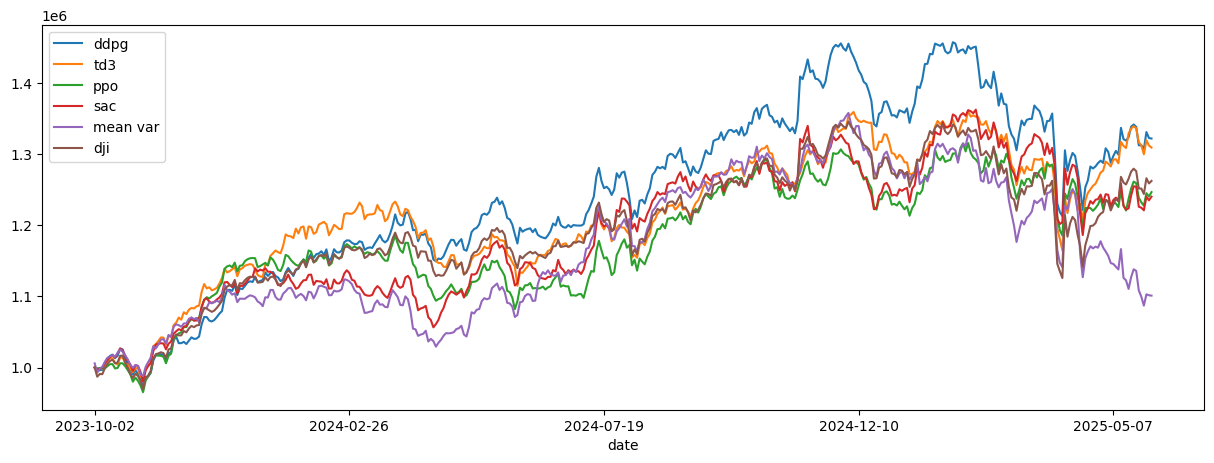

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();